<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Mickael/notebooks/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nussl

In [ ]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

In [ ]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np
import concurrent.futures
import time
from glob import glob

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def preprocess(music_data,
               freq=8192,
               window_length=1023,
               hop_length=768,
               normalize=True):
  
  # Spectro voix et mix
  voice = music_data['sources']["vocals"]
  mix = music_data['mix']

  # Resampling à 16 kHz (pour data plus light)
  if freq is not None:
    voice.resample(freq,res_type='kaiser_fast')
    mix.resample(freq,res_type='kaiser_fast')

  # Passage en mono
  voice.to_mono()
  mix.to_mono()

  # fft mix et voix (magnitude normalisée et phase)
  stftvoice = voice.stft(window_length=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = mix.stft(window_length=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  if normalize:
    norm = magmix.max()
    magmix /= norm
    magvoice /= norm
    return magmix, magvoice, phasemix, norm

  return magmix, magvoice, phasemix

In [ ]:
def reshape(X_mix, X_voice, patch_size=128):
  # transposition pour mettre le temps en première composante  
  X_mix = X_mix.T
  X_voice = X_voice.T

  # split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
  nimages = X_mix.shape[0]//patch_size   # nombre total d'images
  newsize = nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

  X_mix_resized = X_mix[:newsize]
  X_voice_resized = X_voice[:newsize]

  X_mix = np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 
  X_voice = np.array(np.split(X_voice_resized, nimages, axis=0))

  X_mix = np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
  X_voice = np.expand_dims(X_voice,axis=3)

  return X_mix, X_voice

In [ ]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

In [35]:
from tensorflow.keras.models import load_model
import tensorflow as tf

models = glob(os.path.join("/content","drive","MyDrive","Projet Datascientest","UNet","model*"))
print(models)
i = 3
print(models[i])
def myloss(y_true, y_pred):
  return tf.math.reduce_sum(abs(y_true - y_pred)) + abs(tf.math.reduce_sum(y_true) - tf.math.reduce_sum(y_pred))
unet = load_model(models[i], custom_objects={'myloss': myloss})

['/content/drive/MyDrive/Projet Datascientest/UNet/model_20220122_8389ac2af3ba2c49', '/content/drive/MyDrive/Projet Datascientest/UNet/model_20220124_empty', '/content/drive/MyDrive/Projet Datascientest/UNet/model_20220127_keep_all', '/content/drive/MyDrive/Projet Datascientest/UNet/model_20220127_long_train_sd+ds', '/content/drive/MyDrive/Projet Datascientest/UNet/model_20220101_init', '/content/drive/MyDrive/Projet Datascientest/UNet/model_20220124_test', '/content/drive/MyDrive/Projet Datascientest/UNet/model_20220126_init2', '/content/drive/MyDrive/Projet Datascientest/UNet/model_20220125_sd+ds']
/content/drive/MyDrive/Projet Datascientest/UNet/model_20220127_long_train_sd+ds


(512, 2241, 1)
(17, 128, 512, 1)
AudioSignal (unlabeled): 209.908 sec @ AM Contra - Heart Peripheral, 8192 Hz, 1 ch.


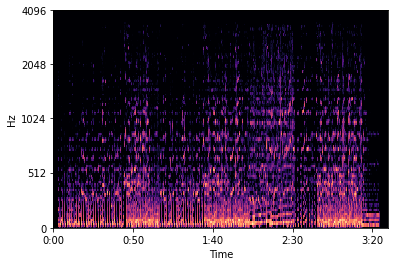

AudioSignal (unlabeled): 209.908 sec @ musdb/AM Contra - Heart Peripheral_vocals.wav, 8192 Hz, 1 ch.


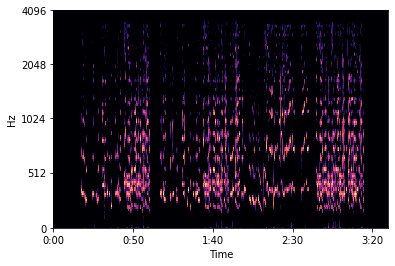

(17, 128, 512, 1)
(512, 2176, 1)
AudioSignal (unlabeled): 203.906 sec @ path unknown, 8192 Hz, 1 ch.


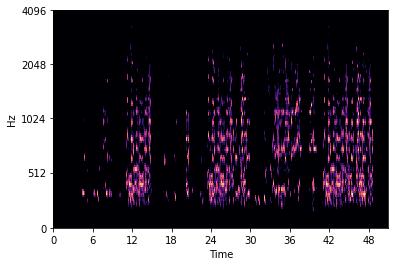

In [32]:
data = musdb_test[0]

# ATTENTION A UTILISER LES BONS
window_length = 1023
hop_length = 768

magmix, magvoice, phase, norm = preprocess(data)
print(magmix.shape)
X_mix, X_voice = reshape(magmix[:,:,0], magvoice[:,:,0], 128)
print(X_mix.shape)

print(data["mix"])
data["mix"].embed_audio()
nussl.utils.visualize_spectrogram(data["mix"], y_axis='mel')
plt.show()

print(data["sources"]["vocals"])
data["sources"]["vocals"].embed_audio()
nussl.utils.visualize_spectrogram(data["sources"]["vocals"], y_axis='mel')
plt.show()

X_voice_pred =unet.predict(X_mix)
print(X_voice_pred.shape)
magmix_pred = X_voice_pred.reshape(-1,512,1).transpose(1,0,2)
print(magmix_pred.shape)
end = magmix_pred.shape[1]
audio_pred = nussl.AudioSignal(stft=magmix_pred*norm*phase[:,:end],sample_rate=8192)
audio_pred.istft(window_length=window_length,hop_length=hop_length)
print(audio_pred)
audio_pred.embed_audio()
nussl.utils.visualize_spectrogram(audio_pred, y_axis='mel')
plt.show()

